## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [79]:
import numpy as np
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

In [584]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

Firstly, we shall use camera calibration doe as from sample repo: 
https://github.com/udacity/CarND-Camera-Calibration/blob/master/camera_calibration.ipynb

In [6]:
# do camera calibration as from sample repo
# https://github.com/udacity/CarND-Camera-Calibration/blob/master/camera_calibration.ipynb
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        #' Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

#cv2.destroyAllWindows()

In [11]:
img = cv2.imread('camera_cal/calibration2.jpg')
img_size = (img.shape[1], img.shape[0])

# based on "Correcting for Distortion" Udacity vid
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

def undistort_image(image):    
    return cv2.undistort(image, mtx, dist, None, mtx)

dst = undistort_image(img)

In [10]:
import pickle
# pickle dump result
dist_info = {}
dist_info["mtx"] = mtx
dist_info["dist"] = dist
with open("camera_cal/dist_pickle.pkl", "wb") as f:
    pickle.dump(dist_info, f)

## Colour Correction

Removing all yellow lanes to white

In [230]:
def yellow_to_white(img1):
    """
    transforms/masks yellow to white...
    """
    img = img1.copy()
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
        keep_mask_color = (0,) * channel_count
    else:
        ignore_mask_color = 255
        keep_mask_color = 0
    
    # yellow mask
    y_lwr = np.array([190, 190, 0])
    y_upr = np.array([255, 255, 160])
    yellow_mask = cv2.inRange(img, y_lwr, y_upr)
    
    img[yellow_mask > 0] = ignore_mask_color
    
    # dark mask... mask
    w_lwr = np.array([0, 0, 200])
    w_upr = np.array([125, 125, 255])
    white_mask = cv2.inRange(img, w_lwr, w_upr)    
    
    img[white_mask > 0] = keep_mask_color
    
    return img.copy()

In [152]:
def col_equalise(img):
    # equalize histograms
    lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    # split by channel
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return final

def hls_filter(img, thresh=(0, 255)):
    """
    applies filter to S channel
    output is binary mask.    
    """
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def color_correction(img1, median_blur=5):
    img = img1.copy()
    if median_blur:
        img = cv2.medianBlur(img, median_blur)
    img = col_equalise(img)
    img = yellow_to_white(img)
    ###img = red_to_black(img) # removed...
    return img

In [217]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    thresh_min, thresh_max = thresh
    try:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    except:
        gray = img.copy()
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, magnitude_thresh=(0, 255)):
    # Convert to grayscale
    thresh_min, thresh_max = magnitude_thresh
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh_min) & (gradmag <= thresh_max)] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output


In [532]:
def abs_sobel_thresh_single(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # same as above for single channel case
    thresh_min, thresh_max = thresh
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    #binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return scaled_sobel

In [601]:
def threshold_pipeline(image, thresh=245):
    """
    This pipeline is based on using only R and S channels
    (see HLS and Color Thresholds)
    """
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    def equalise(img, mode='CLAHE'):
        """single channel image"""        
        if mode == 'CLAHE':
            img = clahe.apply(img)
        else:
            img = cv2.equalizeHist(img)
        #img = cv2.medianBlur(img, 5)
        return img
        
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    R = image[:,:,0]
    S = hls[:,:,2]
    
    # then equalise...
    R_c = equalise(R, mode='CLAHE')
    S_c = equalise(S, mode='CLAHE')
    
    R_hist = equalise(R, mode='hist')
    S_hist = equalise(S, mode='hist')
    
    RS = np.median([R_c, S_c, R_hist, S_hist], axis=0)
    RS[RS < thresh] = 0
    RS[RS >= thresh] = 1
    return RS

    

In [602]:
def sobel_pipeline(image, sobel_kernel=3, 
                   gradx_thresh=(0, 255), 
                   grady_thresh=(0, 255), 
                   magnitude_thresh=(0, 255), 
                   dir_thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Apply each of the thresholding functions
    # initialize
    gradx = np.ones_like(gray)
    grady = np.ones_like(gray)
    mag_binary = np.zeros_like(gray)
    dir_binary = np.zeros_like(gray)
    
    if gradx_thresh:
        gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=sobel_kernel, thresh=gradx_thresh)
        combined = np.zeros_like(gradx)
       
    if grady_thresh:
        grady = abs_sobel_thresh(image, orient='y', sobel_kernel=sobel_kernel, thresh=grady_thresh)
        combined = np.zeros_like(grady)
        
    if magnitude_thresh:
        mag_binary = mag_thresh(image, sobel_kernel=sobel_kernel, magnitude_thresh=magnitude_thresh)
        combined = np.zeros_like(mag_binary)
        
    if dir_thresh:
        dir_binary = dir_threshold(image, sobel_kernel=sobel_kernel, thresh=dir_thresh)
        combined = np.zeros_like(dir_binary)
    
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

In [615]:
def combined_pipeline(image, 
                      sobel_config={"sobel_kernel"     : 5, 
                        "gradx_thresh"     : (30, 255), 
                        "grady_thresh"     : (30, 255), 
                        "magnitude_thresh" : (40, 100), 
                        "dir_thresh"       : (0.7, 1.3)}, 
                      thres_config={'thresh': 200}):
    #sobel_config['image'] = yellow_to_white(image)
    #thres_config['image'] = image
    sobel_img = sobel_pipeline(image=yellow_to_white(image), **sobel_config)
    thres_img = threshold_pipeline(image=image, **thres_config)
    
    combined = np.zeros_like(sobel_img)
    combined[(sobel_img==1) | (thres_img==1)] = 1
    return combined

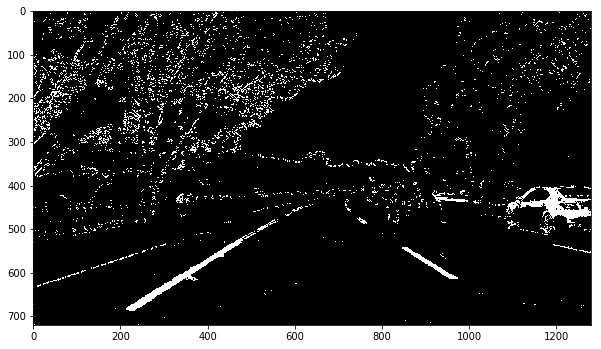

In [617]:
img = mpimg.imread('test_images/test5.jpg')
R = combined_pipeline(img)
plt.imshow(R, cmap='gray')